# Time Series Forecasting with SARIMA Model

https://medium.com/analytics-vidhya/sarima-forecasting-seasonal-data-with-python-and-r-2e7472dfad83

https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
df = pd.read_excel("data/Retail2.xlsx")

In [2]:
y = df.set_index(['Date'])
y.head(5)

,Car sales
Date,
2015-06-01,67
2015-07-01,68
2015-08-01,66
2015-09-01,86
2015-10-01,84


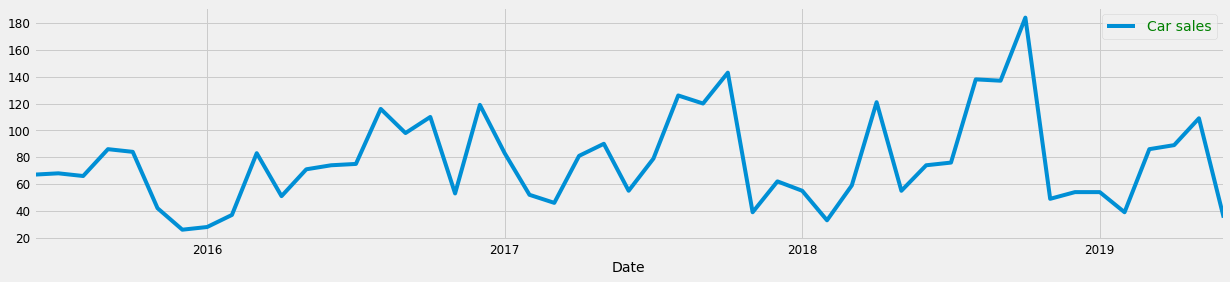

In [3]:
y.plot(figsize=(19, 4))
plt.show()

## Decompose the time series

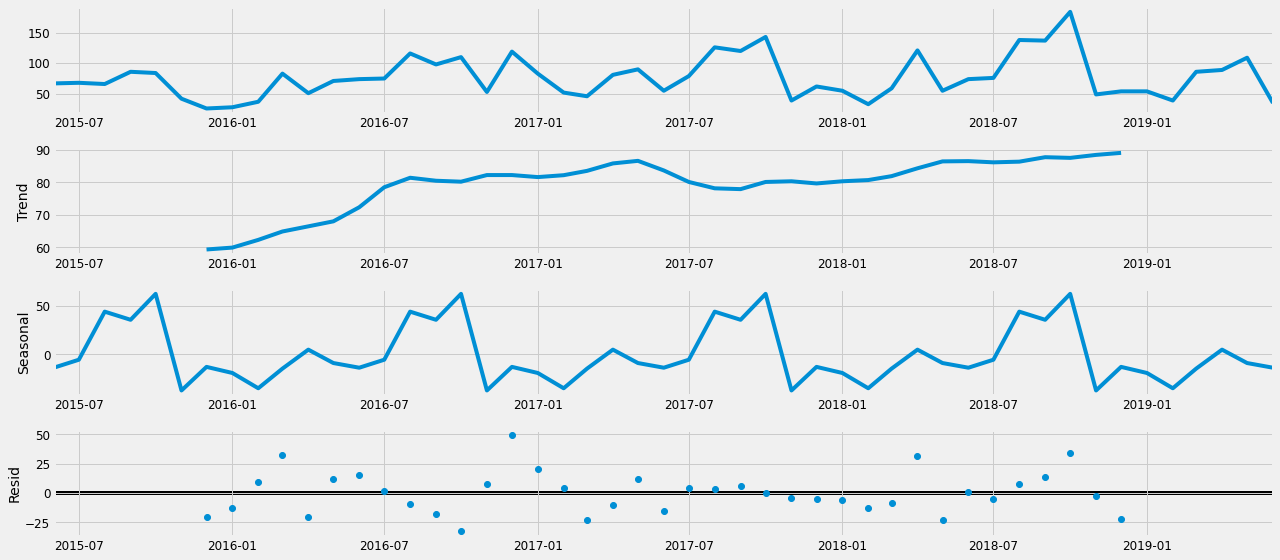

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## SARIMA model

In [5]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
seasonal_pdq[4]

(1, 0, 0, 12)

In [7]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             continue

In [8]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2084      0.282     -0.739      0.460      -0.761       0.344
ar.S.L12      -0.3157      0.184     -1.720      0.085      -0.675       0.044
ma.S.L12       0.3337      0.439      0.760      0.447      -0.527       1.194
sigma2       650.7902    264.392      2.461      0.014     132.592    1168.989


/home/mattiaguerri/Dropbox/project_X/.venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/mattiaguerri/Dropbox/project_X/.venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


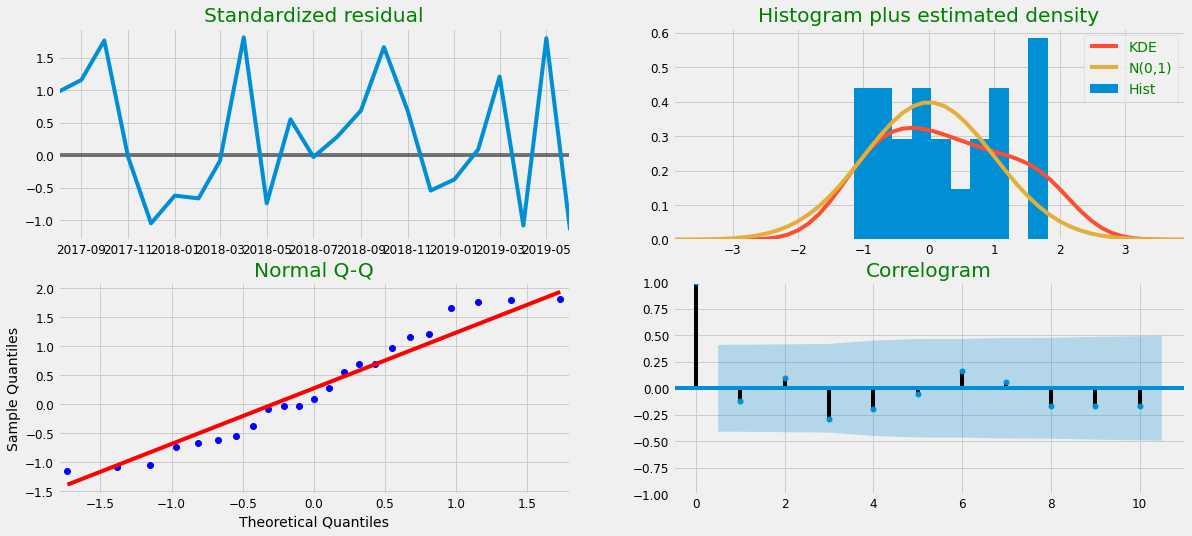

In [9]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [10]:
y.tail()

,Car sales
Date,
2019-02-01,39
2019-03-01,86
2019-04-01,89
2019-05-01,109
2019-06-01,35


## Get Predictions

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2018-06-01'), dynamic=False)
print(type(pred))

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


In [12]:
pred_ci = pred.conf_int()
print(type(pred_ci))

<class 'pandas.core.frame.DataFrame'>


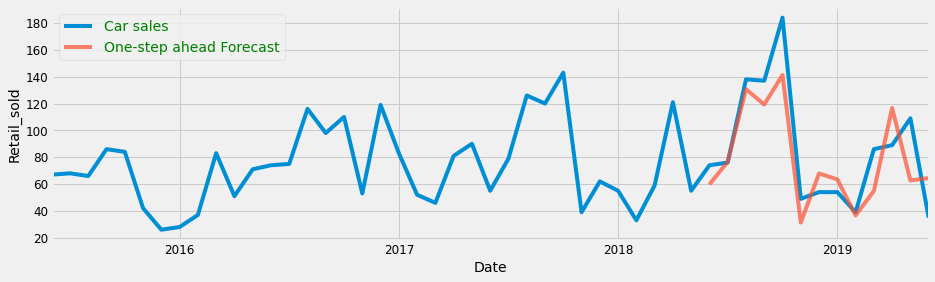

In [13]:
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [14]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-06-01':]

In [15]:
# Convert y_truth in np array
# print(y_truth.columns)
# print(type(y_truth["Car sales"]))
# print(y_truth["Car sales"])
y_truth_np = np.asarray(y_truth["Car sales"], dtype=float)
y_truth_np

array([ 74.,  76., 138., 137., 184.,  49.,  54.,  54.,  39.,  86.,  89.,
       109.,  35.])

In [16]:
# Convert y_forecasted in np array
# print(type(y_forecasted))
y_forecasted_np = np.asarray(y_forecasted, dtype=float)
y_forecasted_np

array([ 59.72770169,  76.65253704, 130.65506346, 119.26511523,
       141.23487591,  31.35632303,  67.89865088,  63.49101265,
        36.66866507,  54.85233976, 116.70931074,  62.69881973,
        64.39968869])

In [17]:
y_forecasted = pred.predicted_mean
mse = ((y_forecasted_np - y_truth_np) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 595.97
The Root Mean Squared Error is 24.41


## Get forecasts

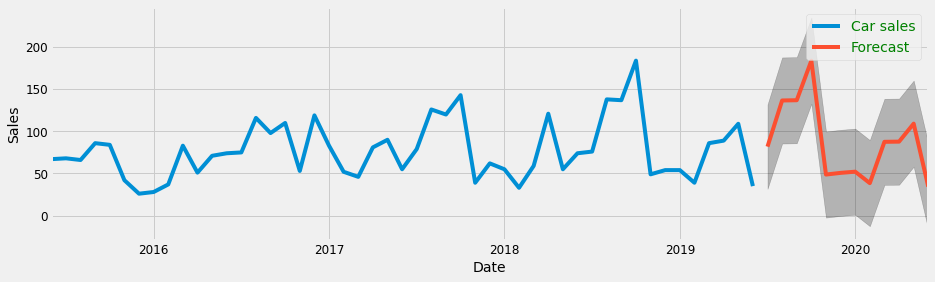

In [18]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()